In [1]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from scipy.signal import resample
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import re

# Correct dataset path
processed = Path().absolute() / "Puentener2023_DataCode" / "Puenter2023_DataCode"

assert processed.is_dir(), "Processed folder does not exist!"

# List all files in the folder
for f in processed.iterdir():
    print(f.name)

.DS_Store
00_Random_sampled_raw_traces
01_Example_raw_movies
02_All_extracted_traces
03_Processed_and_filtered_traces
04_Deep_learning
Readme.rtf
Translation_compound_names.txt


In [2]:
# Point to the folder you want to explore
all_extracted = processed / "03_Processed_and_filtered_traces"

assert all_extracted.is_dir(), "03_Processed_and_filtered_traces folder does not exist!"

# List all files and subfolders inside
for f in all_extracted.iterdir():
    print(f.name)

.DS_Store
Add_transform_traces_incl_mirrored.py
Filtered_processed_augmented
Picasso_get_trace_manuscript_names.py
Picasso_trace_processing_local_version.py


In [3]:
# Pick one file to explore
filtered = all_extracted / "Filtered_processed_augmented"

assert filtered.is_dir(), "Filtered_processed_augmented folder does not exist!"

# List all files and subfolders inside
for f in filtered.iterdir():
    print(f.name)

.DS_Store
.ipynb_checkpoints
C1_7000_filtered_traces_z-scored.pickle
C1_7000_min_max_traces_filtered_incl_mirrored.pickle
C1_7000_zscored_filtered_incl_mirrored.pickle
C2_7000_filtered_traces_z-scored.pickle
C2_7000_min_max_traces_filtered_incl_mirrored.pickle
C2_7000_zscored_filtered_incl_mirrored.pickle
C3_7000_filtered_traces_z-scored.pickle
C3_7000_min_max_traces_filtered_incl_mirrored.pickle
C3_7000_zscored_filtered_incl_mirrored.pickle
C4_7000_filtered_traces_z-scored.pickle
C4_7000_min_max_traces_filtered_incl_mirrored.pickle
C4_7000_zscored_filtered_incl_mirrored.pickle
E1_7000_filtered_traces_z-scored.pickle
E1_7000_min_max_traces_filtered_incl_mirrored.pickle
E1_7000_zscored_filtered_rm_faulty_aq_incl_mirrored.pickle
E2_7000_filtered_traces_z-scored.pickle
E2_7000_min_max_traces_filtered_rm_faulty_aq_incl_mirrored.pickle
E2_7000_zscored_filtered_rm_faulty_aq_incl_mirrored.pickle
E3_7000_filtered_traces_z-scored.pickle
E3_7000_min_max_zscored_traces_filtered_incl_mirrored.pick

In [4]:
# Folder path
filtered = all_extracted / "Filtered_processed_augmented"

# Loop through files
for f in filtered.iterdir():
    if f.suffix == ".pickle":  # only process pickle files
        try:
            # First try pandas.read_pickle
            data = pd.read_pickle(f)
        except Exception as e1:
            try:
                # If that fails, fall back to pickle.load
                with open(f, "rb") as handle:
                    data = pickle.load(handle)
            except Exception as e2:
                print(f"{f.name}: could not load (read_pickle error: {e1} | pickle.load error: {e2})")
                continue

        # Try to get shape
        if hasattr(data, "shape"):
            shape = data.shape
        elif isinstance(data, (list, dict)):
            shape = f"length {len(data)}"
        else:
            shape = type(data)

        print(f"{f.name}: {shape}")

C1_7000_filtered_traces_z-scored.pickle: (6000, 878)
C1_7000_min_max_traces_filtered_incl_mirrored.pickle: (6000, 1756)
C1_7000_zscored_filtered_incl_mirrored.pickle: (6000, 1756)
C2_7000_filtered_traces_z-scored.pickle: (6000, 1786)
C2_7000_min_max_traces_filtered_incl_mirrored.pickle: (6000, 3572)
C2_7000_zscored_filtered_incl_mirrored.pickle: (6000, 3572)
C3_7000_filtered_traces_z-scored.pickle: (6000, 2485)
C3_7000_min_max_traces_filtered_incl_mirrored.pickle: (6000, 4970)
C3_7000_zscored_filtered_incl_mirrored.pickle: (6000, 4970)
C4_7000_filtered_traces_z-scored.pickle: (6000, 799)
C4_7000_min_max_traces_filtered_incl_mirrored.pickle: (6000, 1598)
C4_7000_zscored_filtered_incl_mirrored.pickle: (6000, 1598)
E1_7000_filtered_traces_z-scored.pickle: (6000, 5613)
E1_7000_min_max_traces_filtered_incl_mirrored.pickle: (6000, 11226)
E1_7000_zscored_filtered_rm_faulty_aq_incl_mirrored.pickle: (6000, 11226)
E2_7000_filtered_traces_z-scored.pickle: (6000, 5694)
E2_7000_min_max_traces_filte

In [5]:
def load_blinko(path: Path) -> dict:
    data = dict()
    for file in path.rglob('*.pickle'):
        dict_name = '_'.join(file.stem.split('_')[2:])
        subset = data.get(dict_name, dict())
        compound = file.name.split('_')[0]
        subset[compound] = pd.read_pickle(file)
        data[dict_name] = subset
    if (s := 'all_particles_reordered') in data:
        data['dict_particle_df'] = data.pop(s)
    return data

proc = load_blinko(filtered)

# Inspect available preprocessing keys
for k in proc.keys():
    print("Available preprocessing:", k)

Available preprocessing: filtered_traces_z-scored
Available preprocessing: min_max_traces_filtered_incl_mirrored
Available preprocessing: zscored_filtered_incl_mirrored
Available preprocessing: zscored_filtered_rm_faulty_aq_incl_mirrored
Available preprocessing: min_max_traces_filtered_rm_faulty_aq_incl_mirrored
Available preprocessing: min_max_zscored_traces_filtered_incl_mirrored


In [6]:
# laden wir mal die fertig pre-processed traces
proc = load_blinko(filtered)

In [7]:
for k, v in proc.items():
    print(len(v), k)

10 filtered_traces_z-scored
5 min_max_traces_filtered_incl_mirrored
4 zscored_filtered_incl_mirrored
6 zscored_filtered_rm_faulty_aq_incl_mirrored
4 min_max_traces_filtered_rm_faulty_aq_incl_mirrored
1 min_max_zscored_traces_filtered_incl_mirrored


In [8]:
for k, v in proc.items():
    # Extract particle labels (prefix before "_7000")
    particles = sorted({fname.split("_")[0] for fname in v})
    
    print(f"{len(v)} {k}:")
    print("   " + ", ".join(particles))

10 filtered_traces_z-scored:
   C1, C2, C3, C4, E1, E2, E3, P1, P2, P3
5 min_max_traces_filtered_incl_mirrored:
   C1, C2, C3, C4, E1
4 zscored_filtered_incl_mirrored:
   C1, C2, C3, C4
6 zscored_filtered_rm_faulty_aq_incl_mirrored:
   E1, E2, E3, P1, P2, P3
4 min_max_traces_filtered_rm_faulty_aq_incl_mirrored:
   E2, P1, P2, P3
1 min_max_zscored_traces_filtered_incl_mirrored:
   E3


In [9]:
file_path = filtered / "E1_7000_zscored_filtered_rm_faulty_aq_incl_mirrored.pickle"

data = pd.read_pickle(file_path)
print("Loaded with pd.read_pickle")
print("Type:", type(data))
print("Shape:", data.shape)
print("Column names:", data.columns)

Loaded with pd.read_pickle
Type: <class 'pandas.core.frame.DataFrame'>
Shape: (6000, 11226)
Column names: Index(['Particle 3', 'Particle 7', 'Particle 9', 'Particle 14', 'Particle 19',
       'Particle 22', 'Particle 28', 'Particle 32', 'Particle 33',
       'Particle 37',
       ...
       'Particle 37047_m', 'Particle 37049_m', 'Particle 37052_m',
       'Particle 37054_m', 'Particle 37063_m', 'Particle 37076_m',
       'Particle 37090_m', 'Particle 37092_m', 'Particle 37102_m',
       'Particle 37115_m'],
      dtype='object', length=11226)


In [10]:
data

,Particle 3,Particle 7,Particle 9,Particle 14,Particle 19,Particle 22,Particle 28,Particle 32,Particle 33,Particle 37,...,Particle 37047_m,Particle 37049_m,Particle 37052_m,Particle 37054_m,Particle 37063_m,Particle 37076_m,Particle 37090_m,Particle 37092_m,Particle 37102_m,Particle 37115_m
0,1.322804,0.482764,0.217811,0.133487,1.065284,0.931216,0.236696,0.564642,1.977987,0.636890,...,-0.770206,0.939031,-0.360817,-0.511608,-1.465904,-0.239331,1.098944,0.011633,0.603331,-0.291793
1,5.008551,-0.083543,-0.220733,1.066368,0.945173,2.929348,0.839404,-0.095226,3.337690,1.250557,...,0.193012,-0.024655,1.507424,0.036324,0.898281,-0.208838,-0.099493,-1.188119,0.678346,-0.206496
2,7.410543,2.552268,2.894337,3.291530,0.561592,0.104657,0.807530,0.491129,4.099733,0.901177,...,-0.191363,-0.582408,-0.915572,0.208590,-0.014651,-0.193592,-0.539912,0.236103,0.703797,-0.259681
3,3.504326,5.637648,1.644084,6.257372,2.404587,0.551228,0.916191,2.021778,4.367536,1.181482,...,-1.264141,-0.244671,0.299017,-0.030092,0.504496,0.141833,0.961236,-1.638607,1.143167,-1.143754
4,1.401590,0.718725,1.849778,7.076963,7.299436,0.733487,0.038209,0.367732,2.085762,2.061439,...,0.123623,-0.995648,-0.536979,-0.905953,-0.308146,0.312318,1.139885,-0.915659,-0.184321,0.556155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,-0.923602,-0.323975,-0.305223,0.140519,0.159930,-0.702397,0.631499,-0.601942,-0.283103,-1.341262,...,-0.847812,-1.076023,-1.050011,-0.373587,-0.221130,0.251331,-1.021272,-1.228369,-1.854733,-1.822112
5996,-0.534305,0.004383,-0.054770,0.166302,0.464728,-1.033289,0.113547,-0.504800,-0.445309,0.522765,...,-0.683471,0.511989,0.991301,0.145288,-0.035299,-0.736925,-0.850067,-1.036408,-0.820605,-0.435292
5997,-0.416456,-0.735293,-0.136746,-0.317327,0.524138,-0.559145,-0.328342,0.315222,-0.008767,-0.332164,...,0.069756,-0.601893,-1.130365,-0.641327,1.545740,-1.105615,0.590291,-0.319653,-0.279429,0.588266
5998,0.271435,0.171295,-0.097518,-0.356392,-0.640810,0.021934,0.979215,-0.416409,-0.358219,-0.756626,...,0.098059,-0.005982,0.017776,0.069532,0.573814,-0.799297,-0.685064,0.036403,0.281840,-0.456365


This looks promising! :)

In [11]:
n_timepoints, n_particles = data.shape
print(f"Timepoints (rows): {n_timepoints}")
print(f"Particles (columns): {n_particles}")

Timepoints (rows): 6000
Particles (columns): 11226


In [12]:
data.T

,0,1,2,3,4,5,6,7,8,9,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
Particle 3,1.322804,5.008551,7.410543,3.504326,1.401590,0.598498,-0.079462,3.721486,3.972410,0.017200,...,-0.393946,-0.905064,-0.257559,0.543546,-0.648843,-0.923602,-0.534305,-0.416456,0.271435,-0.658774
Particle 7,0.482764,-0.083543,2.552268,5.637648,0.718725,0.575161,-0.229094,0.031705,0.262699,0.114168,...,-0.693565,-0.255422,-0.074105,-0.101427,-0.020455,-0.323975,0.004383,-0.735293,0.171295,-0.107884
Particle 9,0.217811,-0.220733,2.894337,1.644084,1.849778,1.487174,3.705040,9.094302,8.101040,7.141977,...,-0.261469,0.130303,-0.471186,-0.268007,-0.285609,-0.305223,-0.054770,-0.136746,-0.097518,-0.153845
Particle 14,0.133487,1.066368,3.291530,6.257372,7.076963,0.205368,1.048398,0.695247,1.022615,1.182783,...,-0.458743,-0.104811,-0.389988,0.447573,0.119424,0.140519,0.166302,-0.317327,-0.356392,-0.136845
Particle 19,1.065284,0.945173,0.561592,2.404587,7.299436,0.927091,1.410119,1.490193,0.686869,1.442407,...,-1.259447,-0.538780,0.396278,-1.211660,-0.890073,0.159930,0.464728,0.524138,-0.640810,0.795357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Particle 37076_m,-0.239331,-0.208838,-0.193592,0.141833,0.312318,-0.333583,0.109954,0.888916,0.773874,0.431518,...,-0.304476,0.022633,-1.034926,1.138406,0.486960,0.251331,-0.736925,-1.105615,-0.799297,-1.694687
Particle 37090_m,1.098944,-0.099493,-0.539912,0.961236,1.139885,0.510891,0.629991,-0.425775,0.699465,0.426529,...,-0.516340,0.777624,0.241677,0.050622,0.942626,-1.021272,-0.850067,0.590291,-0.685064,-0.848826
Particle 37092_m,0.011633,-1.188119,0.236103,-1.638607,-0.915659,-1.640155,-0.364547,-0.974486,0.663370,0.942022,...,0.986916,-0.810391,-0.220577,-1.641703,0.047239,-1.228369,-1.036408,-0.319653,0.036403,-0.576632
Particle 37102_m,0.603331,0.678346,0.703797,1.143167,-0.184321,-0.203075,-1.159509,-0.192358,-0.911694,-0.714781,...,-1.206394,-0.805870,-0.696027,0.435888,0.157263,-1.854733,-0.820605,-0.279429,0.281840,0.133151


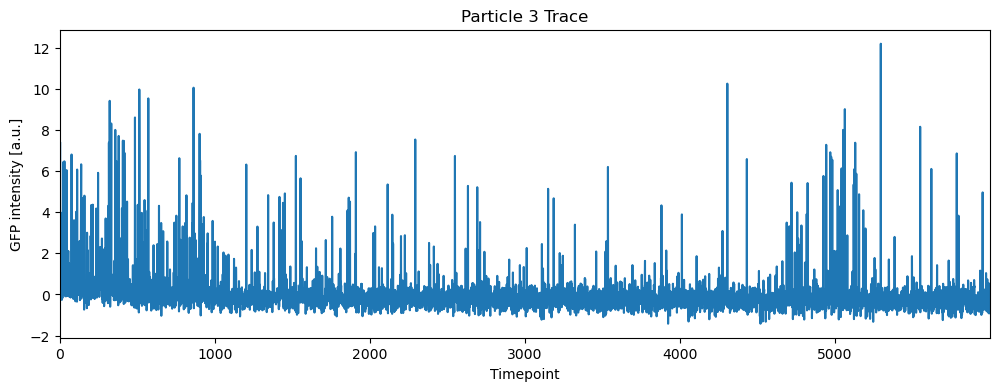

In [13]:
# Select by column name
particle = data["Particle 3"]

plt.figure(figsize=(12, 4))
plt.plot(particle.index, particle.values)
plt.xlabel("Timepoint")
plt.ylabel("GFP intensity [a.u.]")
plt.title("Particle 3 Trace")

# Set x-axis limits to min and max of the timepoints
plt.xlim(particle.index.min(), particle.index.max())

plt.show()

In [14]:
def load_and_sample_renamed(folder, file_dict, n_samples_per_label, n_timepoints=None, random_sample=True, output_file=None):
    """
    folder: Path to folder with pickles
    file_dict: dict of labels and filenames, e.g. {"C1": "C1_7000_all_particles_reordered.pickle"}
    n_samples_per_label: dict of number of traces per label, e.g. {"C1": 100, "C2": 150}
    n_timepoints: int or None, number of timepoints to keep from start
    random_sample: True for random traces, False for first N traces
    output_file: filename to save TSV
    """
    all_data = []

    for label, fpath in file_dict.items():
        file = folder / fpath

        try:
            data = pd.read_pickle(file)
        except Exception as e:
            print(f"⚠️ pd.read_pickle failed for {file}, trying pickle.load... ({e})")
            import pickle
            with open(file, "rb") as f:
                data = pickle.load(f, encoding="latin1")

        # Transpose so particles are rows
        long_df = data.T.reset_index()  
        long_df.rename(columns={"index": "trace_ID"}, inplace=True)
        long_df["label"] = label

        # Sample traces
        n_samples = n_samples_per_label.get(label, len(long_df))
        if random_sample:
            long_df = long_df.sample(n=n_samples, random_state=42, replace=False)
        else:
            long_df = long_df.iloc[:n_samples]

        # Rename trace_IDs: always trace_<particleNumber>[_m]
        new_ids = []
        for tid in long_df["trace_ID"].astype(str):
            match = re.search(r"(\d+)(_m)?$", tid)
            if match:
                num, suffix = match.groups()
                suffix = suffix or ""
                new_ids.append(f"trace_{num}{suffix}")
            else:
                # fallback in case the format is unexpected
                new_ids.append(f"trace_{tid}")
        long_df["trace_ID"] = new_ids

        # Select only the first n_timepoints if specified
        time_cols = [col for col in long_df.columns if col not in ["label", "trace_ID"]]
        if n_timepoints is not None:
            time_cols = time_cols[:n_timepoints]

        # Rename time columns to time_0, time_1, ...
        rename_dict = {old: f"time_{i}" for i, old in enumerate(time_cols)}
        long_df.rename(columns=rename_dict, inplace=True)

        # Reorder columns: label, trace_ID, then all selected times
        long_df = long_df[["label", "trace_ID"] + [f"time_{i}" for i in range(len(time_cols))]]

        all_data.append(long_df)

    combined_df = pd.concat(all_data, ignore_index=True)

    # Save to TSV if requested
    if output_file:
        combined_df.to_csv(output_file, sep="\t", index=False)
        print(f"Saved dataset to {output_file}")

    return combined_df

In [ ]:
folder = all_extracted / "Filtered_processed_augmented"
file_dict = {
    "E1": "E1_7000_zscored_filtered_rm_faulty_aq_incl_mirrored.pickle",
    "E2": "E2_7000_zscored_filtered_rm_faulty_aq_incl_mirrored.pickle"
}
n_samples_per_label = {"E1": 11226, "E2": 11388}
n_timepoints = 6000  # e.g., keep time_0 to time_199

combined_df = load_and_sample_renamed(
    folder, 
    file_dict, 
    n_samples_per_label, 
    n_timepoints=n_timepoints,
    random_sample=False,
    output_file="Püntener/E1_E2_zscored_filtered_traces_aug_dataset_full_balanced.tsv"
)

In [ ]:
combined_df

In [ ]:
def clusmapsns(df: pd.DataFrame, dateiname='plot.png', y_label='GFP intensity [a.u.]', cluster=False):
    df = df.copy()
    
    # Exclude non-trace columns (label, trace_ID)
    trace_df = df.drop(columns=["label", "trace_ID"]).T  # transpose: rows=timepoints, cols=traces
    
    # Create label color mapping
    trace_labels = df['label']
    label_palette = {"E1": "red", "E2": "blue"}
    col_colors = trace_labels.map(label_palette)  # colors for columns (traces)
    
    # Create clustermap
    g = sns.clustermap(
        trace_df,
        row_cluster=False,        # cluster timepoints? usually False
        col_cluster=cluster,      # cluster traces if True
        col_colors=col_colors,    # matches columns = traces
        dendrogram_ratio=(0.001, 0.001),
        cmap="Greys_r",
        figsize=(20, 10),
        xticklabels=False,
        yticklabels=False,
        cbar_pos=(1, 0.08, 0.02, 0.6)
    )

    # Adjust colorbar size and position to match heatmap height exactly
    heatmap_pos = g.ax_heatmap.get_position()
    cbar_width = 0.02
    cbar_x = heatmap_pos.x1 + 0.01
    g.cax.set_position([cbar_x, heatmap_pos.y0, cbar_width, heatmap_pos.height])
    
    # Add black border around colorbar
    for spine in g.cax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.5)
        spine.set_visible(True)
    
    # Colorbar label
    g.cax.set_ylabel(y_label, rotation=270, labelpad=15, fontsize=12)
    g.ax_heatmap.set_xlabel('')
    
    # Save figure
    g.savefig(dateiname, dpi=300)
    
    return g

In [ ]:
g = clusmapsns(df=combined_df, dateiname='Püntener/Heatmap_zscored_E1_E2.png')
# Show and save
plt.show()

In [ ]:
def hack(df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply min-max normalization (0, 1) to trace columns only.
    Keeps 'label' and 'trace_ID' untouched.
    """
    df = df.copy()
    scaler = MinMaxScaler()

    # Identify only trace columns (timepoints)
    trace_cols = [c for c in df.columns if c not in ["label", "trace_ID"]]

    # Scale each trace independently across all timepoints
    df[trace_cols] = scaler.fit_transform(df[trace_cols].T).T  

    return df


def clusmapsns_norm(df: pd.DataFrame, dateiname='plot.png', y_label='GFP intensity [a.u.]',
               cluster=False, hack_flag=True):
    df = df.copy()

    # Optionally normalize using hack()
    if hack_flag:
        df = hack(df)
    
    # Exclude non-trace columns (label, trace_ID)
    trace_df = df.drop(columns=["label", "trace_ID"]).T  # rows=timepoints, cols=traces
    
    # Create label color mapping
    trace_labels = df['label']
    label_palette = {"E1": "red", "E2": "blue"}
    col_colors = trace_labels.map(label_palette)  # colors for columns (traces)
    
    # Create clustermap
    g = sns.clustermap(
        trace_df,
        row_cluster=False,        # cluster timepoints? usually False
        col_cluster=cluster,      # cluster traces if True
        col_colors=col_colors,    # matches columns = traces
        dendrogram_ratio=(0.001, 0.001),
        cmap="Greys_r",
        figsize=(20, 10),
        xticklabels=False,
        yticklabels=False,
        cbar_pos=(1, 0.08, 0.02, 0.6)
    )

    # Adjust colorbar size and position to match heatmap height exactly
    heatmap_pos = g.ax_heatmap.get_position()
    cbar_width = 0.02
    cbar_x = heatmap_pos.x1 + 0.01
    g.cax.set_position([cbar_x, heatmap_pos.y0, cbar_width, heatmap_pos.height])
    
    # Add black border around colorbar
    for spine in g.cax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.5)
        spine.set_visible(True)
    
    # Colorbar label
    g.cax.set_ylabel(y_label, rotation=270, labelpad=15, fontsize=12)
    g.ax_heatmap.set_xlabel('')
    
    # Save figure
    g.savefig(dateiname, dpi=300)
    
    return g

In [ ]:
g = clusmapsns_norm(df=combined_df, dateiname='Püntener/Heatmap_zscored_E1_E2_norm.png')
# Show and save
plt.show()